In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Question 1

In [18]:
def apply_frequency_filter(image, filter_type='ideal', pass_type='low', D0=50, n=2):
    # Convert  to float and normalize
    img = image.astype(np.float32) / 255.0
    M, N = img.shape

    # 2D FT and shift the zero-frequency component to the center for better visualisation
    F = np.fft.fftshift(np.fft.fft2(img))

    # Frequency grid
    u, v = np.meshgrid(np.arange(-M//2, M//2), np.arange(-N//2, N//2), indexing='ij')
    D = np.sqrt(u**2 + v**2)

    # LPF
    if filter_type == 'ideal':
        H = np.double(D <= D0)
    elif filter_type == 'gaussian':
        H = np.exp(-(D**2) / (2 * (D0**2)))
    elif filter_type == 'butterworth':
        H = 1 / (1 + (D / D0)**(2 * n))
    else:
        raise ValueError("filter_type must be 'ideal', 'gaussian', or 'butterworth'")

    # High-pass filter: complement of low-pass
    if pass_type == 'high':
        H = 1 - H

    # Apply filter in frequency domain (correlated in time domain, multiplied in frequency domain)
    G = F * H

    # Inverse and shift back
    g = np.real(np.fft.ifft2(np.fft.ifftshift(G)))

    # rescale
    g = np.clip(g, 0, 1)
    return g


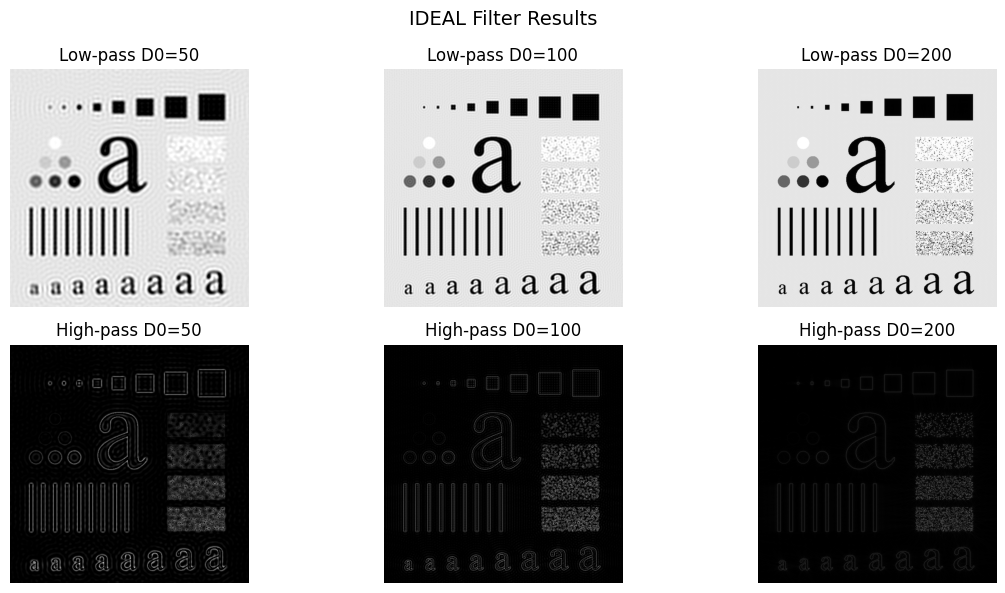

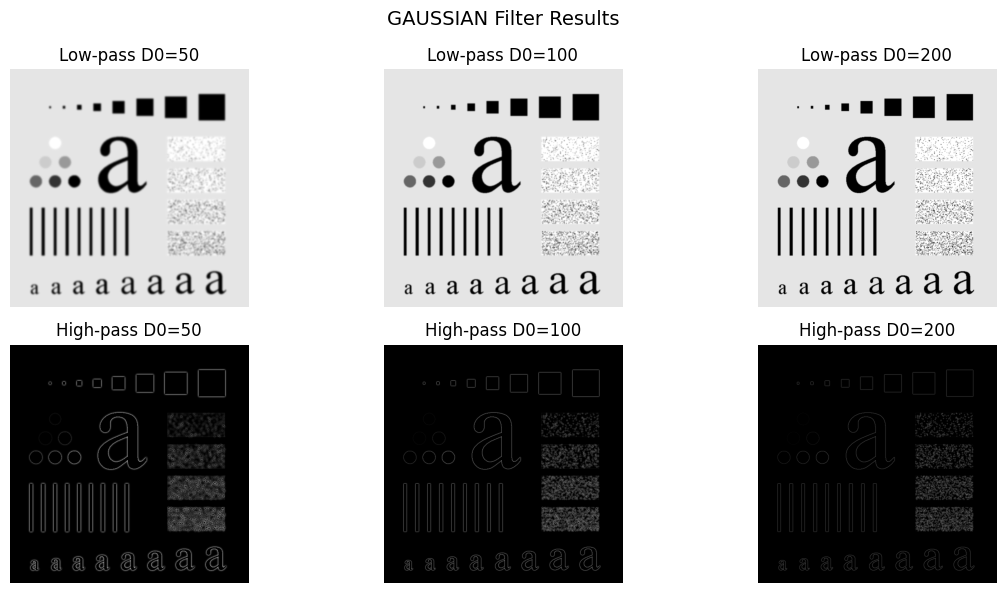

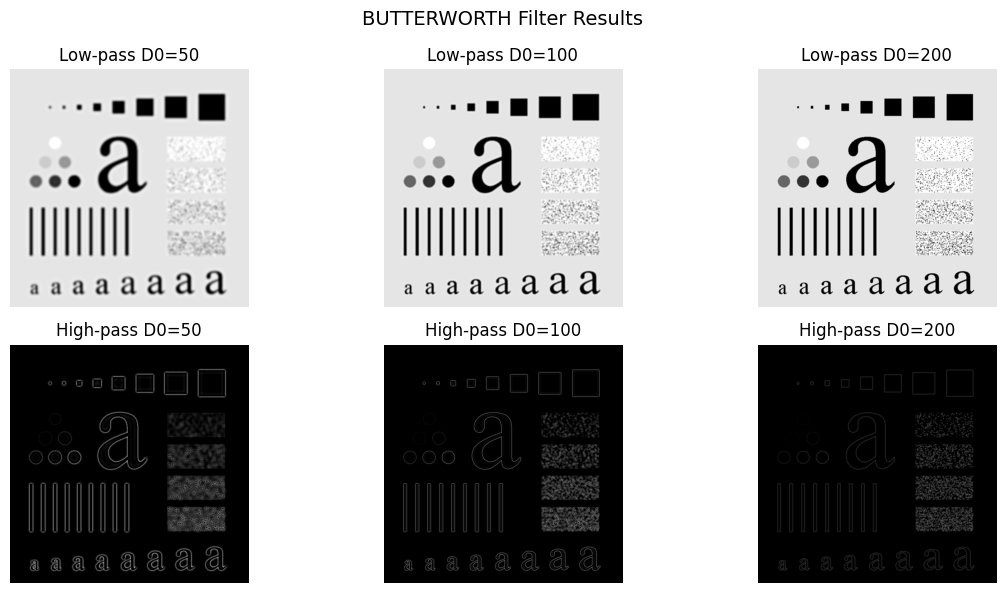

In [19]:
img = cv2.imread('a.tif', cv2.IMREAD_GRAYSCALE)

# parameters
kernel = [50, 100, 200]
filters = ['ideal', 'gaussian', 'butterworth']

for f in filters:
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'{f.upper()} Filter Results', fontsize=14)

    for i, D0 in enumerate(kernel):
        low = apply_frequency_filter(img, f, 'low', D0)
        high = apply_frequency_filter(img, f, 'high', D0)

        # LPF
        plt.subplot(2, len(kernel), i + 1)
        plt.imshow(low, cmap='gray')
        plt.title(f'Low-pass D0={D0}')
        plt.axis('off')

        # HPF
        plt.subplot(2, len(kernel), i + 1 + len(kernel))
        plt.imshow(high, cmap='gray')
        plt.title(f'High-pass D0={D0}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1. Fourier Transform of an Image

$\[F(u, v) = \sum_{x=0}^{M-1}\sum_{y=0}^{N-1} f(x, y) \, e^{-j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)}\]$

$\[f(x, y) = \frac{1}{MN} \sum_{u=0}^{M-1}\sum_{v=0}^{N-1} F(u, v) \, e^{j2\pi\left(\frac{ux}{M} + \frac{vy}{N}\right)}\]$


2. Frequency Domain Filtering

$\[G(u, v) = H(u, v) \cdot F(u, v)\]$

Then the filtered image is obtained using the inverse Fourier transform:

$\[g(x, y) = \mathcal{F}^{-1}\{ G(u, v) \}\]$

$\[D(u, v) = \sqrt{(u - M/2)^2 + (v - N/2)^2}\]$

3. Filters
(a) Ideal Low-Pass Filter

$\[H(u, v) =\begin{cases}1, & D(u, v) \leq D_0 \\0, & D(u, v) > D_0\end{cases}\]$

   - Sharp cutoff at $\( D_0 \)$

(b) Gaussian Low-Pass Filter

$\[H(u, v) = e^{-\frac{D(u,v)^2}{2D_0^2}}\]$

- Smoothly decreases with distance

(c) Butterworth Low-Pass Filter

$\[H(u, v) = \frac{1}{1 + \left(\frac{D(u,v)}{D_0}\right)^{2n}}\]$

- $\( n \)$: filter order (controls the slope of the transition)
- Smoother than ideal but sharper than Gaussian
- Larger $\( n \)$ → steeper transition

An HPF preserves only the edges and sudden changes.

# Question 2

**Noise functions:**

In [20]:
def salt_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    noisy = image.copy()
    total_pixels = image.size
    # Salt
    num_salt = int(total_pixels * salt_prob)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy[coords[0], coords[1]] = 255
    # Pepper
    num_pepper = int(total_pixels * pepper_prob)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy[coords[0], coords[1]] = 0
    return noisy


def sinusoidal_noise(image, direction='horizontal', amplitude=20, frequency=10):
    # Convert to float for safe addition
    img = image.astype(np.float64)

    rows, cols = img.shape

    if direction == 'horizontal':
        x = np.arange(cols)
        sine_wave = amplitude * np.sin(2 * np.pi * frequency * x / cols)
        noise = np.tile(sine_wave, (rows, 1))
    elif direction == 'vertical':
        y = np.arange(rows)
        sine_wave = amplitude * np.sin(2 * np.pi * frequency * y / rows)
        noise = np.tile(sine_wave[:, np.newaxis], (1, cols)) # converts the same 1D sine wave into a column vector.
    else:
        raise ValueError("direction must be 'horizontal' or 'vertical'")

    # Add noise and clip values to make sure they don't surpass the threshold
    noisy_image = np.clip(img + noise, 0, 255).astype(np.uint8)

    return noisy_image

After obtaining the number of salt/ peppers that are going to be applied, we randomly select specific pixels using np.random.randint as it represents the coordinates of num_salt(or num_pepper) pixels that are going to comprise noise. 

- coords[0] is the selected rows and coords[1] is the selected columns, and we allocate either 255 or 0 to create the noise.

**sinusoidal noise:**
if it's applied horizontally, we need cols number of sinusoidal quantities. That's why we have $x / cols$.

    np.tile(..., (rows, 1)):

- Repeat the sine wave rows times vertically.
- Keep its horizontal structure (so it’s identical in every row).

## A

In [21]:
def contraharmonic_mean_filter(img, size=3, Q=1.5):
    eps = 1e-8  # to prevent division by zero
    padded = cv2.copyMakeBorder(img, size//2, size//2, size//2, size//2, cv2.BORDER_REFLECT)
    filtered = np.zeros_like(img, dtype=np.float64)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+size, j:j+size].astype(np.float64)
            
            # Add epsilon before power to avoid division by zero(pepper)
            region_safe = region + eps
            
            num = np.sum(np.power(region_safe, Q + 1))
            den = np.sum(np.power(region_safe, Q))
            
            filtered[i, j] = num / den if den != 0 else 0

    return np.clip(filtered, 0, 255).astype(np.uint8)

# Contraharmonic Mean Filter

$\hat{f}(x, y) = \frac{\sum_{(s, t) \in S_{xy}} [g(s, t)]^{Q + 1}}{\sum_{(s, t) \in S_{xy}} [g(s, t)]^{Q}}$

where:

- $g(s,t)$ is the intensity of a pixel within the neighborhood centered at $(x, y)$  
- $Q$ is the order of the filter (a tunable parameter)  
- $\hat{f}(x, y)$ is the output (filtered) pixel value

If $Q>0$, high intensities (white spots) loom remarkably, while darker pixels contribute less to the pixel. So it is adequate for eliminating pepper noise.

When $Q < 0$, the filter suppresses **salt noise** (bright noise), because negative powers amplify the effect of small gray-level values and reduce the effect of large ones. Therefore, bright pixels (such as salt noise) contribute very little to the sums, so their influence is minimized. Because salt pixels are very large, when there is a negative power, they shrink dramatically toward zero.
So the filter pays attention only to the normal and darker neighbors.

| $Q$ value | Effect                                                
|------------|-------------------------------------------------------
| $Q > 0$ | deteriorates effects of **pepper noise** (black dots) 
| $Q < 0$ | Suppresses **salt noise** (white dots)
| $Q = 0$ | **Arithmetic Mean Filter** (uniform smoothing)


## B

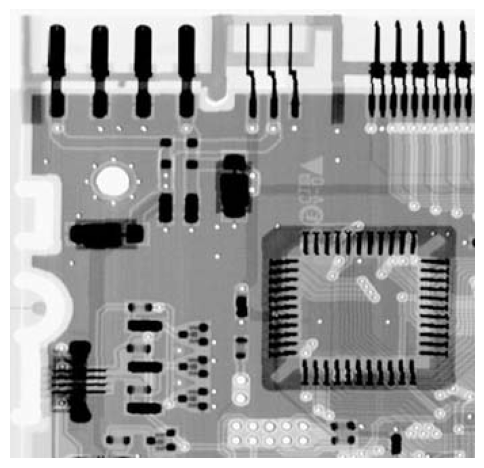

In [22]:
img = cv2.imread('IC.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## C

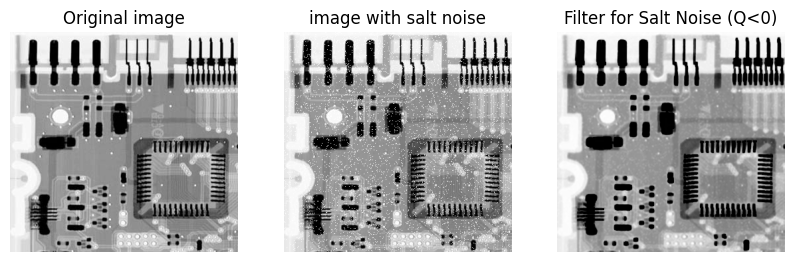

In [23]:
noisy_s = salt_pepper_noise(img, salt_prob=0.05, pepper_prob=0)
filtered_salt = contraharmonic_mean_filter(noisy_s, size=3, Q=-1.5) # AS the image is corrupted with salt noise. q = -1.5  causes the filter to give more weight to darker pixels in the neighborhood, effectively removing bright outliers. 

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(noisy_s, cmap='gray')
plt.title('image with salt noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(filtered_salt, cmap='gray')
plt.title('Filter for Salt Noise (Q<0)')
plt.axis('off')
plt.show()

Regions around black edges receive higher emphasis after filtering. The negative order $Q$ increases the contribution of low-intensity pixels, making edges appear darker and slightly enhancing black details while suppressing bright noise pixels.

## D

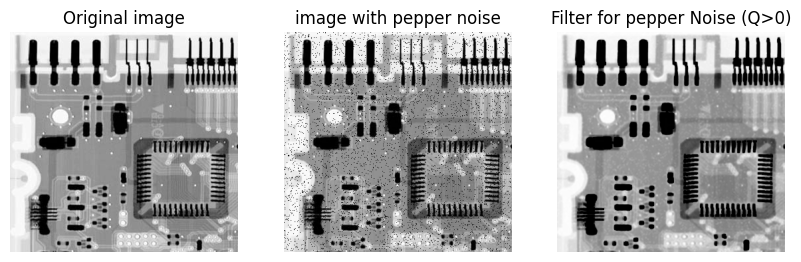

In [24]:
noisy_p = salt_pepper_noise(img, salt_prob=0, pepper_prob=0.05)
filtered_pepper = contraharmonic_mean_filter(noisy_p, size=3, Q=1.5)  # pepper noise

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(noisy_p, cmap='gray')
plt.title('image with pepper noise')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(filtered_salt, cmap='gray')
plt.title('Filter for pepper Noise (Q>0)')
plt.axis('off')
plt.show()

## E

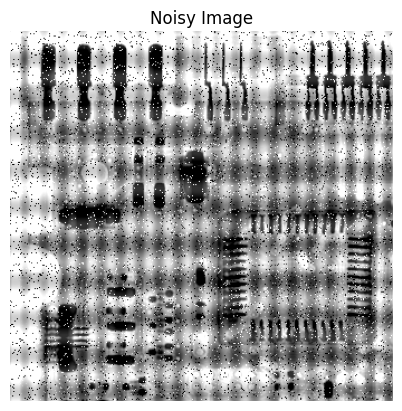

In [25]:
noisy_sp = salt_pepper_noise(img, salt_prob=0.05, pepper_prob=0.05)
noisy_sin_horizontally = sinusoidal_noise(noisy_sp, direction='horizontal', amplitude=40, frequency=20)
final_noisy = sinusoidal_noise(noisy_sin_horizontally, direction='vertical', amplitude=50, frequency=10)
plt.imshow(final_noisy, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.show()

### To remove the noise:

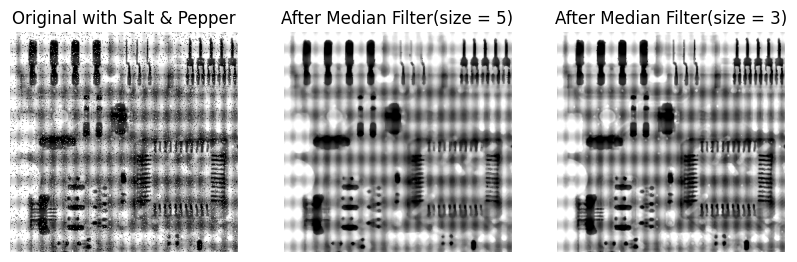

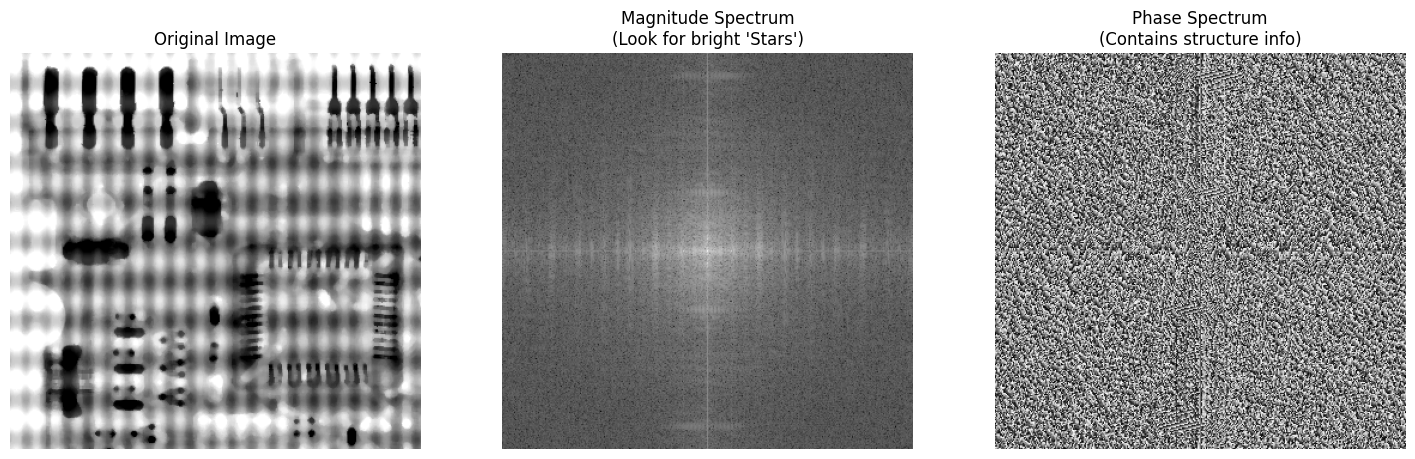

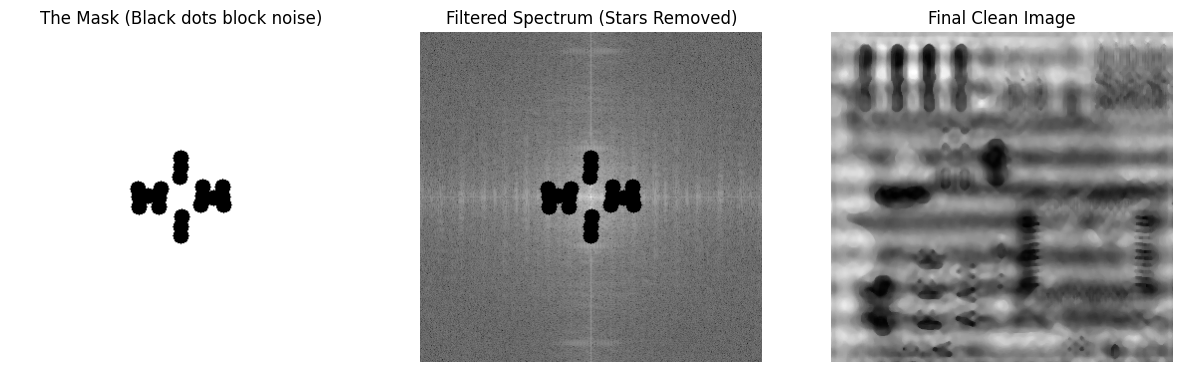

In [46]:
def remove_salt_and_pepper(img): 
    # Using kernel size of 5 and 3
    denoised5_img = cv2.medianBlur(img, 5)
    denoised3_img = cv2.medianBlur(img, 3)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original with Salt & Pepper")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("After Median Filter(size = 5)")
    plt.imshow(denoised5_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("After Median Filter(size = 3)")
    plt.imshow(denoised3_img, cmap='gray')
    plt.axis('off')

    plt.show()

    return denoised5_img, denoised3_img


img_median5, img_median3 = remove_salt_and_pepper(final_noisy)


def analyze_frequency_phase(img_input):
    # 1. Load/Check Image
    if isinstance(img_input, str):
        img = cv2.imread(img_input, 0)
    else:
        img = img_input

    if img is None:
        print("Error: Image is empty.")
        return

    # 2. Perform FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f) # Shift zero freq to center

    # 3. Calculate Magnitude Spectrum
    # We use log because the range of values is huge (0 to millions)
    # The '+1' prevents log(0) errors
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

    # 4. Calculate Phase Spectrum
    # Returns values between -Pi and +Pi
    phase_spectrum = np.angle(fshift)

    # 5. Display
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Magnitude Spectrum\n(Look for bright 'Stars')")
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Phase Spectrum\n(Contains structure info)")
    plt.imshow(phase_spectrum, cmap='gray')
    plt.axis('off')

    plt.show()


analyze_frequency_phase(img_median5)


import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_bright_noise_spots(img):

    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2

    # 2. Convert to Frequency Domain (FFT)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    # Calculate Magnitude (to find where the bright spots are)
    magnitude = 20 * np.log(np.abs(fshift) + 1)

    # 3. Create the Mask (The "Notch Filter")
    # Start with a mask of all 1s (Keep everything)
    mask = np.ones((rows, cols), np.uint8)

    # --- AUTOMATIC STAR REMOVAL ---
    # We will look for the brightest pixels and block them.
    
    # Create a copy of the magnitude to search on
    # We zero out the center so we don't accidentally block the DC component (image brightness)
    search_map = magnitude.copy()
    cv2.circle(search_map, (ccol, crow), 20, 0, -1)

    # We will remove the top 20 brightest spots (adjust this number if noise remains)
    num_peaks = 20
    
    for i in range(num_peaks):
        # Find the brightest spot in the search map
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(search_map)
        
        # If the peak is weak, stop (don't delete real image details)
        if maxVal < 50: 
            break
            
        # 1. Block it on the REAL mask (Draw black circle)
        cv2.circle(mask, maxLoc, 8, 0, -1)
        
        # 2. Zero it on the SEARCH map (so we find the *next* brightest spot)
        cv2.circle(search_map, maxLoc, 8, 0, -1)

    # 4. Apply the Mask
    fshift_masked = fshift * mask

    # 5. Inverse FFT (Convert back to image)
    f_ishift = np.fft.ifftshift(fshift_masked)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Normalize
    img_periodic_removed = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    # 6. Apply Median Filter (Because Salt & Pepper noise is also present)
    final_clean_image = cv2.medianBlur(img_periodic_removed, 5)

    # --- Visualization ---
    plt.figure(figsize=(15, 6))

    # Show the Mask we created
    plt.subplot(1, 3, 1)
    plt.title("The Mask (Black dots block noise)")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    # Show the Filtered Spectrum
    plt.subplot(1, 3, 2)
    plt.title("Filtered Spectrum (Stars Removed)")
    # Apply mask to magnitude for display
    plt.imshow(magnitude * mask, cmap='gray')
    plt.axis('off')

    # Show Final Result
    plt.subplot(1, 3, 3)
    plt.title("Final Clean Image")
    plt.imshow(final_clean_image, cmap='gray')
    plt.axis('off')

    plt.show()

# Run using your variable name
# If you are using the filename string:
remove_bright_noise_spots(img_median5)

# If you are using a variable from a previous cell (e.g., img_median5)
# remove_bright_noise_spots(img_median5) <-- Note: You'd need to modify the load function slightly

There is a periodic noise with salt and pepper noise visible in the image. So notch filter would be beneficial to use. However, we should first use FFT to make sure about the periodic noise and its characteristics. Moreover, salt and pepper noise are vividly noticeable, which can be demolished with a median filter.

Since I figured using a kernel size of 5 is more beneficial, I'll use it for further de-noising process.

# Question 3

## A

In [26]:
def motion_blur(image, LEN, THETA):
    # Create the kernel matrix
    size = int(LEN)
    if size % 2 == 0: 
        size += 1 
    kernel = np.zeros((size, size))
    
    # center
    center = (size // 2, size // 2)
    
    # Calculate angle and line coordinates
    angle_rad = np.deg2rad(THETA) # degree to radian for computation
    x_offset = int((LEN/2) * np.cos(angle_rad))
    y_offset = int((LEN/2) * np.sin(angle_rad))
    
    # motion line
    cv2.line(kernel, (center[0] - x_offset, center[1] - y_offset), (center[0] + x_offset, center[1] + y_offset), 1, thickness=1)
    
    # kernel's sum must be 1
    kernel = kernel / np.sum(kernel)
    
    # Apply the filter
    blurred = cv2.filter2D(image, -1, kernel) # Convolution
    
    # Normalize
    blurred = cv2.normalize(blurred, None, 0, 255, cv2.NORM_MINMAX) # like .clip
    blurred = blurred.astype('uint8')
    
    return blurred, kernel

### Algorithm:

This function simulates the effect of linear motion blur, which occurs when the camera or subject moves during the exposure time. The process involves creating a Point Spread Function (PSF) and convolving it with the image.

1. As mentioned in the class, the mask's matrix symmetry is crucial to advocate for reasonable result. It is mainly due to the fact that we need to find the centre of the mask to apply the filter, which is unattainable if we have even numbers of pixels. So I $add_1$ to the length to retain the matrix symmetry to build a len x len size.
2. $sin$ and $cos$ is then used to form the direction that the kernel must move in.
3. As used in coursework, pixels are then divided by kernel size.
4. image is then correlated with the kernel and $-1$ is written to preserve the input size for the output.

### Theory

#### Modeling Motion Geometry

$\theta_{rad} = \theta_{deg} \times \frac{\pi}{180}$

$\Delta x = \frac{L}{2} \cos(\theta_{rad})$

$\Delta y = \frac{L}{2} \sin(\theta_{rad})$

The line is drawn from $(c_x - \Delta x, c_y - \Delta y)$$to$$(c_x + \Delta x, c_y + \Delta y)$.

#### Energy Preservation (Normalization)
After drawing the line, the kernel $H$ contains 1s along the path and 0s elsewhere. To prevent the image from becoming brighter or darker during blurring, the sum of all elements in the kernel must equal 1. This is called energy preservation:

$H_{normalized}(u,v) = \frac{H(u,v)}{\sum_{i}\sum_{j} H(i,j)}$

#### Convolution and Rescaling

$$g(x,y) = f(x,y) * h(x,y) = \sum_{s=-a}^{a} \sum_{t=-b}^{b} h(s,t) f(x-s, y-t)$$
$$g_{out} = 255 \times \frac{g_{in} - \min(g_{in})}{\max(g_{in}) - \min(g_{in})}$$

## B

(np.float64(-0.5), np.float64(344.5), np.float64(344.5), np.float64(-0.5))

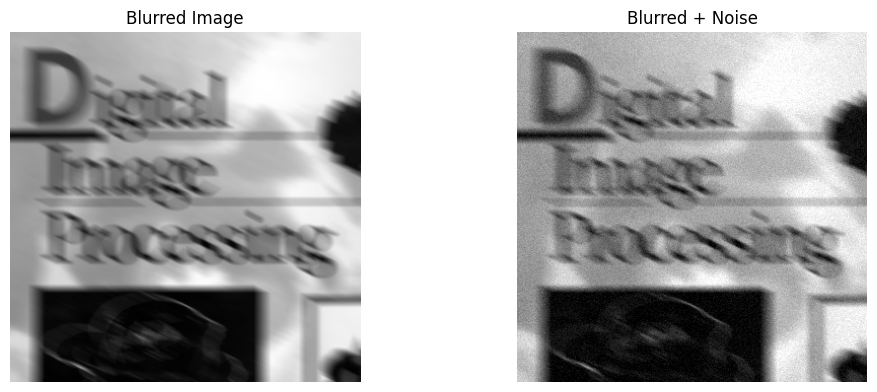

In [27]:
img = cv2.imread('DIP.png', cv2.IMREAD_GRAYSCALE)
blurred_img, psf_kernel = motion_blur(img, 20, 30)

# noise is float
img_float = blurred_img / 255.0
mean = 0
variance = 0.001
sigma = variance ** 0.5 #square root of variance
    
noise = np.random.normal(mean, sigma, img_float.shape)
noisy_img_float = img_float + noise
noisy_img_float = np.clip(noisy_img_float, 0, 1)
    
noisy_img = (noisy_img_float * 255).astype('uint8')

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("Blurred Image")
plt.imshow(blurred_img, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Blurred + Noise")
plt.imshow(noisy_img, cmap='gray')
plt.axis('off')

### 1. Additive White Gaussian Noise
$$g(x,y) = f(x,y) + \eta(x,y)$$
Where:
* $f(x,y)$ is the original (or blurred) image pixel value at coordinates (x, y).
* $\eta(x,y)$ is the noise component added to that pixel.
* $g(x,y)$ is the resulting noisy image.

### 2. Converting to Float
Before adding noise, I convert the image from integer format (0-255) to floating-point format (0.0-1.0) as noise itself is float.

$$\text{pixel}_{float} = \frac{\text{pixel}_{int}}{255.0}$$

### 3. Gaussian Noise Characteristics
$$p(z) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{(z-\mu)^2}{2\sigma^2}}$$

* $\mu = 0$. It does not brighten or darken the overall image, but adds variations around the true pixel value.
* Variance ($\sigma^2$) = 0.001

### 4. Clipping and Restoration
After adding the noise, some pixel values may exceed the valid range. Therefore, rescaling is required. It should subsequently be multiplied by 255 to apply to the normal gray scale.
$$g_{final}(x,y) = \begin{cases} 1 & \text{if } g(x,y) > 1 \\ 0 & \text{if } g(x,y) < 0 \\ g(x,y) & \text{otherwise} \end{cases}$$

$$\text{Output} = \lfloor g_{final}(x,y) \times 255 \rfloor$$

## C

In [50]:
def inverse_filter(input_img, kernel):
    rows, cols = input_img.shape
    padded_kernel = np.zeros((rows, cols))
    k_h, k_w = kernel.shape
    padded_kernel[:k_h, :k_w] = kernel
    
    G = np.fft.fft2(input_img)                   # The Blurred Image
    H = np.fft.fft2(padded_kernel, s=(rows, cols)) # The Blur Filter
    
    # I add a tiny number (epsilon) to avoid dividing by absolute zero
    epsilon = 1e-10
    F_hat = G / (H + epsilon)
    
    # Inverse FFT (Convert back to Image)
    restored = np.fft.ifft2(F_hat)
    restored = np.clip(restored)
    restored = cv2.normalize(restored, None, 0, 255, cv2.NORM_MINMAX)
    return restored.astype('uint8')

In [51]:
restored_img = inverse_filter(noisy_img, psf_kernel)
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("Blurred Image")
plt.imshow(blurred_img, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Image After Restoration")
plt.imshow(restored_img, cmap='gray')
plt.axis('off')

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'normalize'
> Overload resolution failed:
>  - src data type = complex128 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


# Algorithm Explanation: Inverse Filtering

Inverse filtering is a restoration technique that attempts to recover the original image from a blurred image by reversing the degradation process in the frequency domain.

### 1. The Convolution Theorem
In the spatial domain, the degraded image $g(x,y)$is produced by the convolution of the original image $f(x,y)$ and the blur kernel $h(x,y)$:

$$g(x,y) = f(x,y) * h(x,y)$$
$$G(u,v) = F(u,v) H(u,v)$$

### 2. Zero Padding
The Fast Fourier Transform (FFT) requires both the image and the kernel to be of the same size to perform element-wise arithmetic.

### 3. The Inverse Formula
To recover the original image $F(u,v)$, we simply divide the blurred spectrum by the kernel spectrum:

$$\hat{F}(u,v) = \frac{G(u,v)}{H(u,v)}$$

To prevent computational crashes or "Exploding" values, we add a tiny regularization term ($\epsilon$) to the denominator:

$$\hat{F}(u,v) = \frac{G(u,v)}{H(u,v) + \epsilon}$$

### 4. Restoration to Spatial Domain
After obtaining the estimate $\hat{F}(u,v)$, we apply the Inverse Fast Fourier Transform (IFFT) to return to the pixel domain. Finally, the pixel intensities are normalized to the 0-255 range for valid display.

$$\hat{f}(x,y) = | \mathcal{F}^{-1}\{ \hat{F}(u,v) \} |$$

## D

In [ ]:
def wiener_filter(input_img, kernel, K=0.01):
    rows, cols = input_img.shape
    
    # Pad kernel
    padded_kernel = np.zeros((rows, cols))
    k_h, k_w = kernel.shape
    padded_kernel[:k_h, :k_w] = kernel
    
    # FFT
    G = np.fft.fft2(input_img)
    H = np.fft.fft2(padded_kernel, s=(rows, cols))
    
    # Wiener Formula
    H_abs_sq = np.abs(H) ** 2
    W = np.conj(H) / (H_abs_sq + K)
    F_hat = W * G
    
    # Inverse FFT
    restored = np.fft.ifft2(F_hat)
    restored = np.abs(restored)
    
    # Normalize result here for display
    restored = cv2.normalize(restored, None, 0, 255, cv2.NORM_MINMAX)
    return restored.astype('uint8')

## E

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Make sure you have the functions 'motion_blur' and 'wiener_filter' defined from previous steps ---

# Setup parameters
params = [
    (20, 30),  # 1. Baseline
    (60, 30),  # 2. High LEN (Harder to restore)
    (20, 0),   # 3. Horizontal Blur (Look at vertical lines)
    (20, 90)   # 4. Vertical Blur (Look at horizontal lines)
]

# Noise settings (keep constant for fair comparison)
variance = 0.001
sigma = variance ** 0.5

plt.figure(figsize=(15, 5))
plt.suptitle("Part E: Effect of LEN and THETA on Reconstruction Quality")

for i, (L, T) in enumerate(params):
    # 1. Create the Degradation (Blur)
    b_img, k = motion_blur(img, L, T)
    
    # 2. Add Noise (Crucial! Wiener needs noise to show its behavior)
    img_float = b_img / 255.0
    noise = np.random.normal(0, sigma, img_float.shape)
    noisy_img_float = np.clip(img_float + noise, 0, 1)
    noisy_img = (noisy_img_float * 255).astype('uint8')
    
    # 3. RESTORE the image (This was missing!)
    restored_img = wiener_filter(noisy_img, k, K=0.01)
    
    # 4. Plot the RESTORED image
    plt.subplot(1, 4, i+1)
    plt.title(f"Restored\nL={L}, T={T}")
    plt.imshow(restored_img, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\filter.dispatch.cpp:1528: error: (-215:Assertion failed) !_src.empty() in function 'cv::filter2D'


<Figure size 1500x500 with 0 Axes>

LEN: Increasing Length makes the blur stronger (more zero-crossings in frequency), making it harder to restore details.

THETA: Changing Angle changes the direction of the blur. Horizontal blur destroys vertical lines; Vertical blur destroys horizontal lines.